In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from numpy import exp
from scipy import ndimage
from func import *

In [2]:
def create_3_arcsec_minicube(wo_cube,wo_err,wo_header,cont_cube,brightest_pixel_x,brightest_pixel_y,sampling_rate,box_size=3):
    if sampling_rate == 0.4:
        mini_cube_data = wo_cube[:,brightest_pixel_y-box_size:brightest_pixel_y+box_size+1,brightest_pixel_x-box_size:brightest_pixel_x+box_size+1]
        mini_cube_err = wo_err[:,brightest_pixel_y-box_size:brightest_pixel_y+box_size+1,brightest_pixel_x-box_size:brightest_pixel_x+box_size+1]
    else:
        mini_cube_data = wo_cube[:,brightest_pixel_y-2*box_size:brightest_pixel_y+2*box_size+1,brightest_pixel_x-2*box_size:brightest_pixel_x+2*box_size+1]
        mini_cube_err = wo_err[:,brightest_pixel_y-2*box_size:brightest_pixel_y+2*box_size+1,brightest_pixel_x-2*box_size:brightest_pixel_x+2*box_size+1]
    wo_header['CRPIX1'] = wo_header['CRPIX1'] - (brightest_pixel_x-box_size)
    wo_header['CRPIX2'] = wo_header['CRPIX2'] - (brightest_pixel_y-box_size)
    return mini_cube_data, mini_cube_err,wo_header

def fit(int_spectrum,int_error,mini_wave,p_init,broad2=False,MC_loops=10,min_wave=4750,max_wave=5090):
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
    (spectrum,error) = (int_spectrum,int_error)   
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(mini_wave,spectrum,error),maxfev = 10000000)       
    fitted=(full_gauss(popt_full_fit,mini_wave,spectrum,error))*(error)+spectrum 
    residual = spectrum - fitted
    
    spec_parameters_MC = np.zeros((len(popt_full_fit),MC_loops))
    for l in range(MC_loops):
        iteration_data = np.random.normal(spectrum,error)   
        popt_spec_MC,pcov_spec_MC = leastsq(full_gauss,x0=popt_full_fit,args=(mini_wave,iteration_data,error),maxfev = 10000000)
        spec_parameters_MC[:,l]=popt_spec_MC
    spec_parameters_err = np.std(spec_parameters_MC,1)
    return popt_full_fit,spec_parameters_err,fitted,residual

def central_table(obj,output_par,output_par_err):
    column_names={'amp_Hb':0,'amp_OIII5007':1,'vel_OIII':2,'vel_sigma_OIII':3,'amp_Hb_br':4,'amp_OIII5007_br':5,'vel_OIII_br':6,
              'vel_sigma_OIII_br':7,'amp_Hb1':8,'amp_Fe5018_1':9,'vel_Hb1':10,'vel_sigma_Hb1':11,'amp_Hb2':12,
              'amp_Fe5018_2':13,'vel_Hb2':14,'vel_sigma_Hb2':15,'m':16,'c':17}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[output_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[output_par_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_non_spectro_central_fit.fits'%(obj),overwrite=True)
    
def plot(mini_wave,int_spectrum,output_par,fitted,residual):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit) = output_par
    print output_par
    plt.plot(mini_wave,int_spectrum,'k-',label='data')
    plt.plot(mini_wave,fitted,'r-',label='fit')
    plt.plot(mini_wave,residual,label='residual')
    plt.plot(mini_wave,Hb_O3_gauss(mini_wave,amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit) + continuum(mini_wave,m_fit,c_fit),label='core',color = 'green')
    plt.plot(mini_wave,Hb_O3_gauss(mini_wave,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit) + continuum(mini_wave,m_fit,c_fit),label='wing',color ='magenta')
    plt.plot(mini_wave,Hb_Fe_doublet_gauss(mini_wave,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + continuum(mini_wave,m_fit,c_fit),label='BLR1',color ='blue')
    plt.plot(mini_wave,Hb_Fe_doublet_gauss(mini_wave,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit) + continuum(mini_wave,m_fit,c_fit),label='BLR2',color = 'orange')
    plt.title('%s_integrated spectrum (Free parameter fit)'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)")
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$) ")
    plt.legend()
    plt.show()

In [3]:
def spectroastrometric_script(obj,z,broad2,asymmetry,p_init,box_size=7,min_wave=4750,max_wave=5090,MC_loops=5,prefix_path_cube="/home/mainak/xdata/ftp.hidrive.strato.com/users/login-carsftp"):
    #try:
        #(orig_cube,orig_err,orig_wave,orig_header) = loadCube('%s/MUSE/%s/%s.binned.fits'%(prefix_path_cube,obj,obj))
    #except IOError:
        #(orig_cube,orig_err,orig_wave,orig_header) = loadCube('%s/MUSE/%s/%s.unbinned.fits'%(prefix_path_cube,obj,obj))  
    #(cont_cube,cont_err,cont_wave,cont_header) = loadCube('%s/MUSE/%s/%s.cont_model.fits'%(prefix_path_cube,obj,obj))
    #(QSO_cube,QSO_err,QSO_wave,QSO_header) = loadCube('%s/MUSE/%s/%s.QSO_full.fits'%(prefix_path_cube,obj,obj))
    #(wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s.wo_absorption.fits'%(obj))
    
    #[brightest_pixel_x,brightest_pixel_y] = brightest_pixel(QSO_cube,wo_cube,wo_wave,z)
    #sampling_rate = sampling_size(cont_cube)
    #(mini_cube,mini_err,wo_header)=create_3_arcsec_minicube(wo_cube,wo_err,wo_header,cont_cube,brightest_pixel_x,brightest_pixel_y,sampling_rate,box_size=4)
    #k = 1+z
    #select = (wo_wave > min_wave*k) & (wo_wave < max_wave*k)  
    #mini_header = wo_header
    #mini_wave = wo_wave[select] 
    #mini_cube = mini_cube[select] 
    #mini_err = mini_err[select]
    #store_cube('%s.3_arcsec_minicube.fits'%(obj),mini_cube,mini_wave,mini_err,mini_header)
    print '%s'%(obj)
    (mini_cube,mini_err,mini_wave,mini_header) = loadCube('%s.3_arcsec_minicube.fits'%(obj))
    (int_spectrum,int_error) = int_spec(mini_cube,mini_err)
    (output_par,output_par_err,fitted,residual) = fit(int_spectrum,int_error,mini_wave,p_init,broad2,MC_loops=10,min_wave=4750,max_wave=5090)
    central_table(obj,output_par,output_par_err)
    plot(mini_wave,int_spectrum,output_par,fitted,residual)
    

HE2233+0124
[ 1.21977105e+00  8.90073273e+00  1.69833342e+04  1.67060405e+02
  4.51313879e-01  1.47758945e+00  1.70411009e+04  4.93971787e+02
  1.25923670e+00  5.69579539e-02  1.52004028e+04  1.40725387e+03
  1.88711494e+00  1.10849362e-01  1.83723169e+04  4.09746614e+03
 -3.97122956e-01  4.44827730e+00]


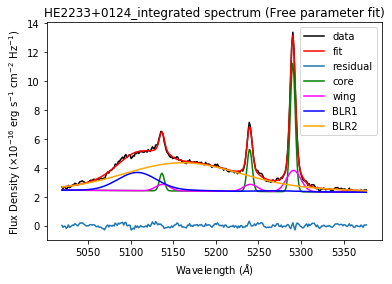

HE0429-0247
[ 1.37402707e+01  1.23025203e+02  1.26342923e+04  1.04032298e+02
  1.52712842e+01  1.04929573e+01  1.26380772e+04  3.37441141e+02
  1.89327619e+01  1.63501429e+00  1.26746836e+04  1.24892613e+03
 -1.14272206e-01  1.90246400e+00  5.88201282e+03  1.10765654e+03
 -5.71032319e+00  4.40205607e+01]


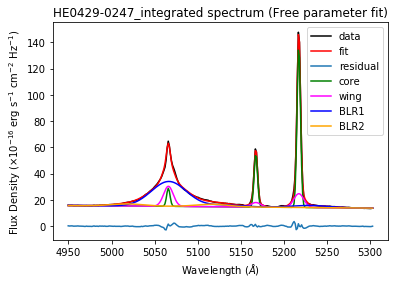

HE0232-0900
[ 7.47297569e+01  7.90352880e+02  1.28678820e+04  1.49377383e+02
 -7.13734816e-01  1.70535448e+02  1.28526341e+04  3.37083757e+02
  1.06586419e+02  1.58170295e+01  1.28837298e+04  2.17500730e+03
  0.00000000e+00  0.00000000e+00  1.29420000e+04  1.00000000e+03
 -5.82639599e+01  4.08617213e+02]


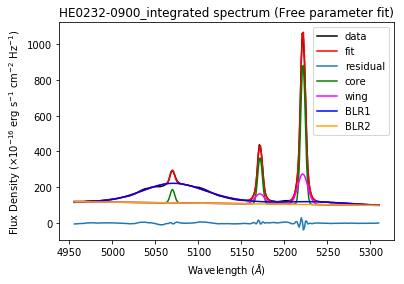

HE2222-0026
[ 2.41303583e+00  7.29130460e+00  1.74211447e+04  1.20964635e+02
 -2.62207780e-01  3.58684075e+00  1.72747108e+04  2.30826105e+02
  3.84692258e+00  5.93612350e-01  1.74127296e+04  1.69635289e+03
  2.76189966e+00  2.29619303e-01  1.85625910e+04  6.24517310e+02
  5.48136133e-02  3.62075969e+00]


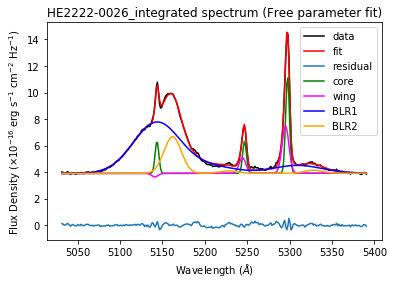

HE0021-1819
[ 4.60772156e+00  4.52594080e+01  1.59577506e+04  8.15547541e+01
  1.28369780e+00  8.98193328e+00  1.58278565e+04  3.01288301e+02
  1.38150789e+00  2.30524128e-01  1.60509236e+04  1.67433883e+03
  0.00000000e+00  0.00000000e+00  1.59590000e+04  1.00000000e+03
 -7.87141522e-01  5.71914482e+00]


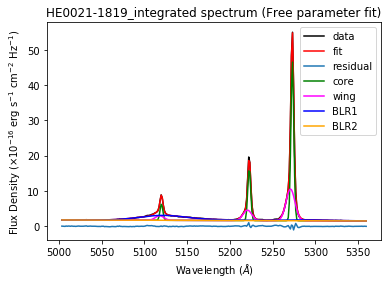

HE0853+0102
[2.67469043e+00 1.48010672e+01 1.57136228e+04 1.08515480e+02
 3.40168803e-01 4.35916691e+00 1.56786854e+04 3.02570603e+02
 1.84160245e+00 3.26903483e-01 1.53750207e+04 1.48348441e+03
 1.24589982e+00 7.53398192e-02 1.71498150e+04 1.02616248e+03
 8.68386232e-03 1.35099929e+00]


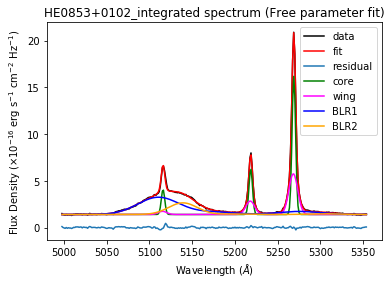

HE1011-0403
[ 5.67229108e+00  3.25300213e+01  1.75356802e+04  1.05312002e+02
  2.40760389e+00  1.71975333e+01  1.73207125e+04  2.57677520e+02
  8.66020600e+00  1.15887524e+00  1.77404288e+04  1.51455427e+03
  2.08849498e+01  2.27294826e+00  1.76593282e+04  7.80840399e+02
 -1.07518061e+01  7.86230282e+01]


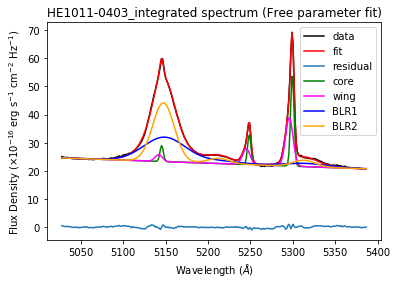

HE0040-1105
[ 7.61040133e+00  9.11178063e+01  1.25686731e+04  7.81636684e+01
  2.59955715e+00  1.63639701e+01  1.24542911e+04  2.63539381e+02
  7.18768037e+00  1.01839844e+00  1.29479483e+04  1.28044179e+03
  0.00000000e+00  0.00000000e+00  1.25070000e+04  1.00000000e+03
 -1.27531342e+00  1.63307481e+01]


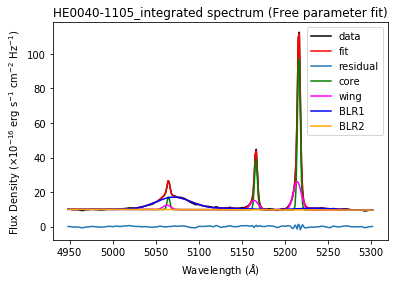

HE0253-1641
[ 2.18931672e+01  2.04064124e+02  9.54555362e+03  1.11077415e+02
  1.12863013e+01  7.01637483e+01  9.30476009e+03  3.65155485e+02
  2.63828683e+01  7.02886839e+00  9.74357437e+03  5.58342856e+02
  1.56163900e+01  3.52200515e+00  9.17522166e+03  1.68406017e+03
 -3.50183711e-01  4.08541016e+01]


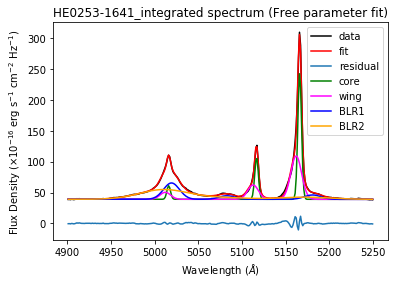

HE0119-0118
[ 5.28665764e+00  9.10174472e+01  1.63332995e+04  1.19587193e+02
  6.38385042e+00  6.27423299e+01  1.61273272e+04  2.55490149e+02
  2.13845317e+01  1.21697338e-01  1.64374259e+04  7.98596949e+01
  1.70157542e+01  3.15429501e+00  1.65440175e+04  1.72241010e+03
 -1.20475852e+01  7.95110831e+01]


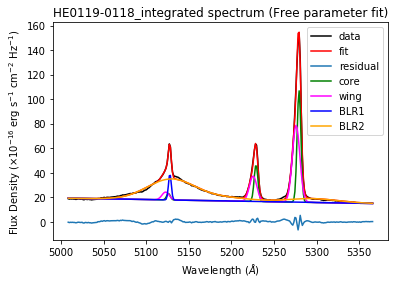

HE0934+0119
[ 8.73996477e+00  5.00410109e+01  1.52069087e+04  8.07439137e+01
  3.75462069e+00  2.34530765e+01  1.50829455e+04  1.73812124e+02
  1.14366803e+01  1.32450174e+00  1.51998435e+04  1.29007617e+03
  2.01789737e+01  2.62604322e+00  1.52010368e+04  5.27073393e+02
 -5.31843959e+00  4.06630985e+01]


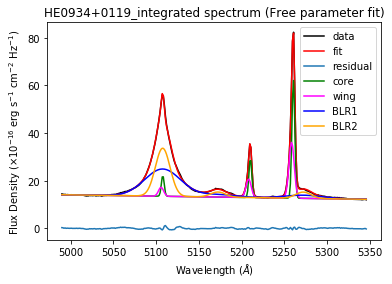

HE1017-0305
[ 2.54656069e+00  3.32164927e+01  1.46820134e+04  6.73569147e+01
  2.29682508e+00  1.19061340e+01  1.46246428e+04  2.11004320e+02
  1.56856946e+01  2.28515206e+00  1.45094307e+04  1.94365633e+03
  0.00000000e+00  0.00000000e+00  1.49950000e+04  1.00000000e+03
 -9.11063774e+00  6.17715522e+01]


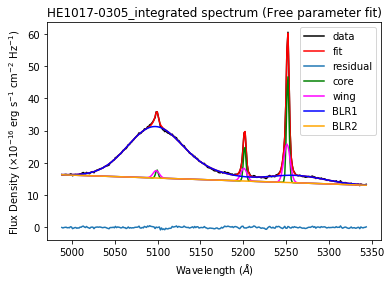

HE0345+0056
[ 1.48601491e+01  1.84661883e+02  9.19858036e+03  1.55131992e+02
  4.49946212e+01  1.23219308e+02  8.86483613e+03  3.88822410e+02
  9.13016011e+01  1.76886018e+01  9.32159098e+03  1.51189725e+03
  2.71937830e+02  2.59847134e+01  9.34361744e+03  3.25842887e+02
 -6.99507932e+00  1.21559404e+02]


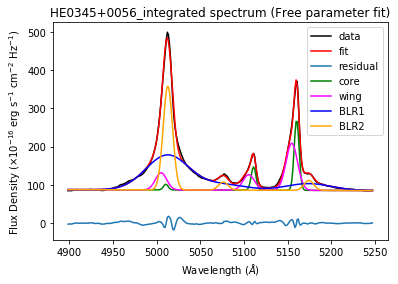

HE0412-0803
[ 9.62686938e+01  1.31113928e+03  1.14767567e+04  8.87186486e+01
  1.96644593e+01  1.81866851e+02  1.14554514e+04  2.55110984e+02
  3.92659168e+01  5.35190874e+00  1.12798445e+04  1.71699639e+03
  0.00000000e+00  0.00000000e+00  1.14480000e+04  1.00000000e+03
 -1.02144220e+01  7.79546986e+01]


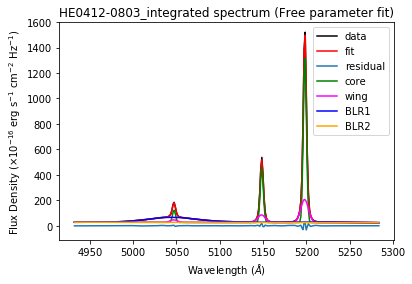

HE0433-1028
[ 1.39830344e+01  8.28303840e+01  1.05903156e+04  1.32528947e+02
  8.43253221e+00  9.07671186e+01  1.02783349e+04  3.36805070e+02
  4.16715122e+01  4.23760828e+00  1.04968908e+04  9.18515663e+02
  2.17073228e+01  5.81327114e+00  1.12101205e+04  2.03101188e+03
 -1.69622402e+01  1.17891885e+02]


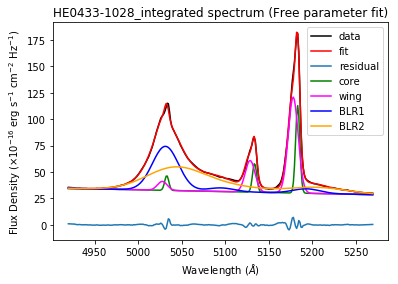

HE1330-1013
[ 4.18787428e+00  1.68240669e+01  6.75090603e+03  8.19913981e+01
  2.43190354e+00  4.01081277e+00  6.60483763e+03  2.31247843e+02
  2.49141439e+00  7.20975019e-01  6.90872528e+03  1.85647723e+03
  7.13188302e+00  1.14438985e+00  6.84017025e+03  6.79740512e+02
 -3.96355883e-01  6.92669518e+00]


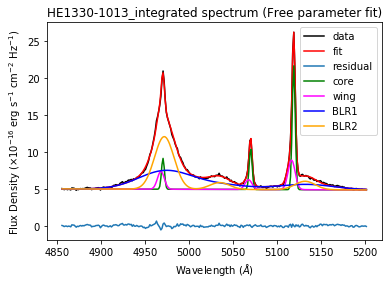

HE1417-0909
[ 7.32052219e+00  1.00830205e+02  1.30842272e+04  7.20393794e+01
  1.64808402e+00  2.08091285e+01  1.30542253e+04  1.87185083e+02
  1.09317979e+01  1.19051313e+00  1.32230052e+04  1.45771501e+03
  0.00000000e+00  0.00000000e+00  1.32000000e+04  1.00000000e+03
 -6.03638370e+00  3.96168999e+01]


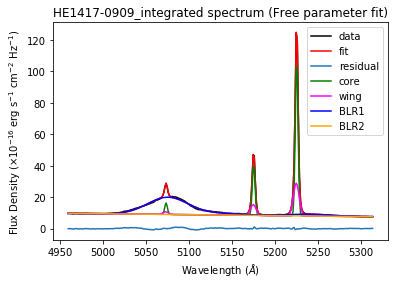

HE0227-0913
[  57.55861322   92.30637586 4796.77735847  143.5632355    30.41899001
    9.14608771 4344.17829084  287.86817535   50.79773544    7.85996918
 4712.05241701 1279.15412997  105.48152542   25.33584857 4919.75042921
  372.63141628   -9.79973649   96.68183083]


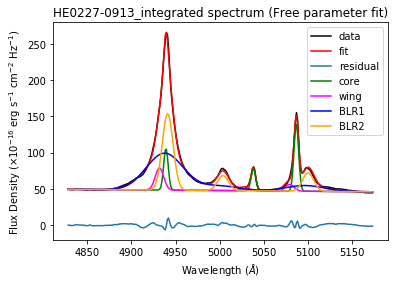

HE1029-1831
[ 2.98773841e+01  9.21944513e+00  1.21264079e+04  8.38621740e+01
  9.08407785e+00  4.05207024e+01  1.19862254e+04  2.20536516e+02
  1.01470691e+01  2.44934193e+00  1.22177565e+04  1.27776668e+03
  4.63439709e+00 -1.07563326e-01  1.29794114e+04  4.39261281e+02
 -2.48787510e-01  1.08132432e+01]


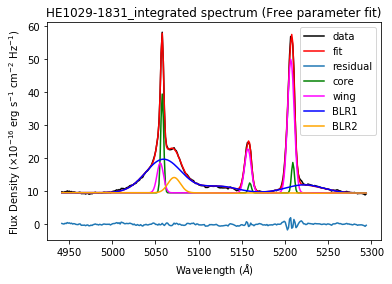

HE2302-0857
[ 2.94512922e+01  2.70034566e+02  1.41022222e+04  1.80131441e+02
  1.01460184e+01  5.00936801e+01  1.42701092e+04  4.55861768e+02
  1.04117284e+01  2.62611631e-01  1.59468938e+04  9.46736812e+02
  2.36960251e+01  7.36434256e+00  1.30305422e+04  2.06605129e+03
 -2.18461057e+01  1.51221970e+02]


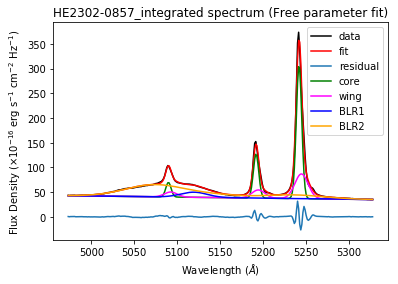

HE1107-0813
[ 2.82209464e+00  8.82804978e+00  1.75529026e+04  8.38475632e+01
  5.18017487e+00  3.05397532e+00  1.74181665e+04  5.12980382e+02
  1.81043434e+01  7.27476326e+00  1.75394113e+04  1.03492191e+03
  1.73459999e+01  1.63119038e+00  1.67913656e+04  2.01700349e+03
 -2.36515536e+01  1.83393941e+02]


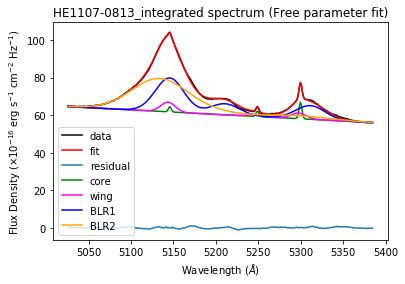

HE2211-3903
[ 8.06156582e+00  4.33225839e+01  1.18609270e+04  7.77190523e+01
  5.14259012e-01  3.84256023e+00  1.17655999e+04  2.16407841e+02
  4.63799123e+00  6.06529971e-01  1.15423393e+04  2.68328972e+03
  0.00000000e+00  0.00000000e+00  1.19140000e+04  1.00000000e+02
 -8.04654944e-01  1.50234006e+01]


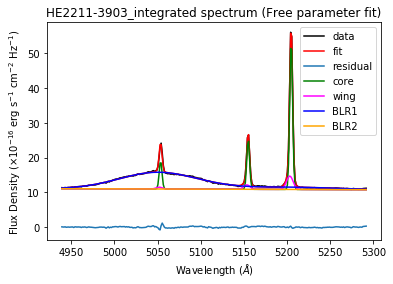

HE1108-2813
[ 2.82243170e+01  4.53566640e+01  7.17061166e+03  7.55223823e+01
  1.17969989e+01  2.83026604e+01  7.05841116e+03  2.34578772e+02
  1.66305369e+01  4.23416493e+00  7.35945785e+03  1.23375435e+03
  0.00000000e+00  0.00000000e+00  7.20000000e+03  1.00000000e+03
 -8.36867284e+00  6.25586636e+01]


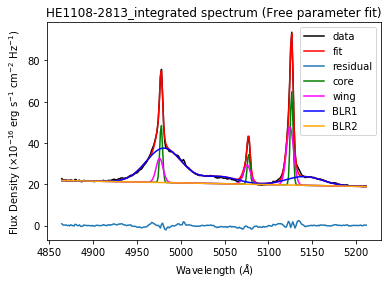

HE1126-0407
[ 1.09620162e+01  1.23852839e+02  1.80353606e+04  1.19876836e+02
  1.93166576e+01  2.31365459e+01  1.77707468e+04  3.47723491e+02
  7.77910693e+01  1.01831352e+01  1.80693431e+04  7.27536622e+02
  5.50766928e+01  1.23237594e+01  1.79838108e+04  1.82490577e+03
 -1.29903551e+01  1.42858436e+02]


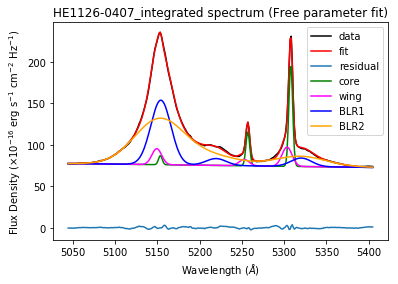

HE0351+0240
[ 1.97935998e+01  3.01161439e+02  1.06388788e+04  7.98842320e+01
  8.40552556e+00  1.81518731e+01  1.06171726e+04  2.45232768e+02
  1.11912821e+01  3.67167802e-01  1.15746411e+04  3.16109468e+02
  2.71162019e+01  2.81726613e+00  1.06633453e+04  1.31947390e+03
 -4.32479274e+00  3.61147768e+01]


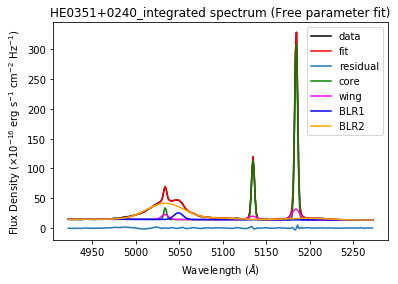

HE0224-2834
[ 7.05538499e+00  7.17652088e+01  1.79848648e+04  1.18423045e+02
  1.49430643e+00  1.86448821e+01  1.79679183e+04  2.75148417e+02
  8.33346609e+00  1.18002326e+00  1.79913856e+04  2.15488136e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.56951603e+00  2.18135816e+01]


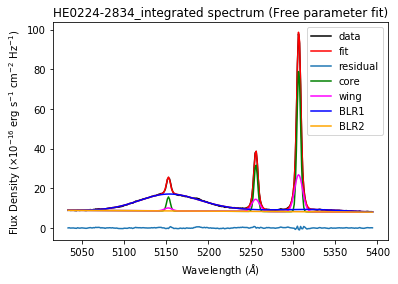

HE1353-1917
[ 5.68870900e+00  4.97596043e+01  1.04988447e+04  1.01050877e+02
  1.38667114e+00  7.75167157e+00  1.03070416e+04  3.50547294e+02
  2.72834653e+00  2.52392693e-02  1.17317512e+04  2.00827377e+03
  2.86988069e+00  8.37416488e-01  8.40741113e+03  1.42506185e+03
 -3.18294946e+00  2.91997627e+01]


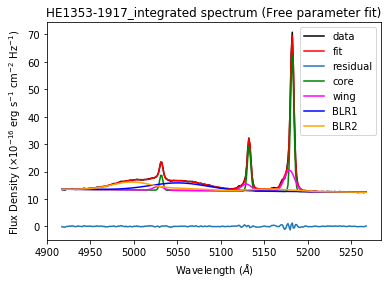

In [4]:
z = {"HE0021-1819":0.053197,"HE0040-1105":0.041692 #,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143,"HE0253-1641":0.031588
    ,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009,"HE0433-1028":0.035550
    ,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986,"HE1029-1831":0.040261
    ,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1330-1013":0.022145,"HE1353-1917":0.035021
    ,"HE1417-0909":0.044,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}

#z_remaining = {"HE2128-0221":0.05248,"HE1248-1356":0.01465}
#p_init_of_them = 'HE0108-4743':[1.139,1.5,7176.0,50.0,1.0,3.0,6976.0,200.0,1.0,1.0,7176,1000.0,1.0,1.0,7176,1000.0,-0.001,2.0]
       # ,'HE0114-0015':[0.1,1.5,13680,50.0,1.0,3.0,13480,100.0,1.0,1.0,13680,1000.0,0,0,13680,1000.0,-0.001,0.3]
       
objs = z.keys()

broad2= {'HE0021-1819':False,'HE0040-1105':False #,'HE0108-4743':True,'HE0114-0015':False
        ,'HE0119-0118':True,'HE0224-2834':False,'HE0227-0913':True,'HE0232-0900':False,'HE0253-1641':True
        ,'HE0345+0056':True,'HE0351+0240':True,'HE0412-0803':False,'HE0429-0247':True,'HE0433-1028':True
        ,'HE0853+0102':True,'HE0934+0119':True,'HE1011-0403':True,'HE1017-0305':False,'HE1029-1831':True
        ,'HE1107-0813':True,'HE1108-2813':False,'HE1126-0407':True,'HE1330-1013':True,'HE1353-1917':True
        ,'HE1417-0909':False,'HE2211-3903':False,'HE2222-0026':True,'HE2233+0124':True,'HE2302-0857':True}

asymmetry = {"HE0021-1819":True,"HE0040-1105":True #,"HE0108-4743":dunno,"HE0114-0015":dunno
    ,"HE0119-0118":False,"HE0224-2834":False,"HE0227-0913":False,"HE0232-0900":False,"HE0253-1641":False
    ,"HE0345+0056":False,"HE0351+0240":False,"HE0412-0803":False,"HE0429-0247":False,"HE0433-1028":False
    ,"HE0853+0102":False,"HE0934+0119":True,"HE1011-0403":False,"HE1017-0305":False,"HE1029-1831":False
    ,"HE1107-0813":False,"HE1108-2813":True,"HE1126-0407":False,"HE1330-1013":True,"HE1353-1917":True
    ,"HE1417-0909":False,"HE2211-3903":False,"HE2222-0026":False,"HE2233+0124":False,"HE2302-0857":False}


p_init= {'HE0021-1819':[1,12.5,15959,50.0,3,3,15759,200.0,2,2,15959,1000.0,0,0,15959,1000.0,-0.001,0.1]
         ,'HE0040-1105':[1.139,1.5,12507.0,50.0,1.0,3.0,12307.0,100.0,1.0,1.0,12507,1000.0,0,0,12507,1000.0,-0.001,2.0]
         ,'HE0119-0118':[22,125,16302,50.0,3,3,16002,100.0,10,1,16302,1000.0,10,1,16302,1500.0,-0.001,0.1]
         ,'HE0224-2834':[7.06899403e+00,7.13458601e+01,1.79847558e+04,1.18000676e+02,1.45515224e+00,1.90068487e+01,1.79693125e+04,2.72340813e+02,8.44672986e+00,9.16885096e-01,1.80245745e+04,2.16641488e+03,0,0,0,0,-2.79613744e+00,2.29434665e+01]  
         ,'HE0227-0913':[15,70,4935,50.0,10,20,4835,100.0,100,20,4935,1000.0,30,10,4935,500.0,-0.001,0.1]
         ,'HE0232-0900':[2,40,12942,50.0,5,5,12742,100.0,5,1,12942,1000.0,0,0,12942,1000.0,-0.001,0.1] 
         ,'HE0253-1641':[21,200,9476,90.0,11,70,9176,200.0,26,7,9476,1000.0,15,3.5,9476,1000.0,-0.001,0.5]
         ,'HE0345+0056':[14,180,9300,155,45,123,9100,400,90,18,9300,1500,270,26,9300,400,-7.0,7.16315181e+00]
         ,'HE0351+0240':[2.19264502e+00,3.70402407e+01,1.06360169e+04,7.72338448e+01,1.10298241e+00,1.50249383e+00,1.06183228e+04,2.77549457e+02,1.52283432e+00,7.54204519e-02,1.15806639e+04,3.17978311e+02,3.47577206e+00,3.51692202e-01,1.06529589e+04,1.34441236e+03,-2.90461186e-01,3.33119886e+00]
         ,'HE0412-0803':[1.139,1.5,11448,50.0,0.1,0.3,11248,100.0,0.1,0.1,11448,1000.0,0,0,11448,1000.0,-0.001,0.5]
         ,'HE0429-0247':[0.3,1,12602,40.0,7,0.2,12502,500.0,0.1,0.1,12602,460.0,0.1,0.1,12602,1000.0,-0.001,0.1]
         ,'HE0433-1028':[10,100,10665.0,20.0,100,1.0,10465.0,200.0,25,1.0,10665,1000.0,55,0.1,10665,2500.0,-0.1,1.0]
         ,'HE0853+0102':[0.1,0.9,15600,50.0,0.1,0.1,15400,100.0,0.1,0.1,15600,1000.0,0.1,0.1,15600,1000.0,-0.001,0.1]
         ,'HE0934+0119':[11,47,15101,50.0,7,24,14901,100.0,28,3.0,15101,1000.0,3,1,15101,1000.0,0.001,0.7]
         ,'HE1011-0403':[6,40,17494,60.0,6,6,17250,200.0,20,4,17494,1000.0,5,3,17494,500.0,0.001,0.7]
         ,'HE1017-0305':[4,35,14995,50,2,3,14895,100,16,3,14995,2000,0,0,14995,1000,-0.3,2.0]
         ,'HE1029-1831':[30,9,12078,30.0,5,45,11978,100.0,5,0.1,12078,1000.0,12,2,12078,1000.0,-0.001,0.2]
         ,'HE1107-0813':[5,10,17400,50,20,3,17200,400,8.66709804e-01,3.59444240e-01,1.75395296e+04,9.89119070e+02,8.77384324e-01,7.64366776e-02,1.68588382e+04,2.00171135e+03,-8.35532281e-01,7.28333927e+00]
         ,'HE1108-2813':[28,35,7200.0,50.0,11,28,7000.0,100.0,16,4.2,7200,1000.0,0,0,7200,1000.0,-8.3,60]
         ,'HE1126-0407':[1.00409949e+00,1.34246331e+01,1.80273208e+04,1.24499810e+02,2.46452048e+00,2.86320853e+00,1.77600119e+04,3.51254916e+02,9.96139933e+00,1.30416561e+00,1.80789175e+04,7.18418498e+02,7.31717375e+00,1.77825637e+00,1.79704287e+04,1.77768741e+03,-9.59655619e-01,1.47131358e+01]                                           
         ,'HE1330-1013':[3,12,6643,88,2,2,6435,215,12,2,6643,1500,3,1,6643,616,-1.74500992e-02,2.87685339e-01]
         ,'HE1353-1917':[6,50,10506.0,100.0,3,10,9906.0,350.0,5,1,10506.0,1000.0,5,1,10506.0,1000.0,-0.001,0.002]
         ,'HE1417-0909':[7,100,13200,50.0,1.6,20,13000,100.0,10,1.2,13200,1000.0,0,0,13200,1000.0,-0.001,0.1]
         ,'HE2211-3903':[10,42,11914,50.0,2,5,11714,100.0,5,1,11914,1000.0,0,0,11914,100.0,-0.001,0.2]
         ,'HE2222-0026':[2,10,17734.0,50.0,2,0.1,17634.0,300.0,3,1.5,17634,2000.0,3,1,17834,500.0,-0.001,0.002]
         ,'HE2233+0124':[3,10,16944.0,170.0,2,2,16744.0,500.0,2,2,16944,1000.0,4,2,16944,4000.0,-0.001,0.01]
         ,'HE2302-0857':[25,220,14058,50,25,50,14258,500,31,15,14058,1500,20,10,14058,1700,-0.9,6.0]}
              
for obj in objs:
    spectroastrometric_script(obj,z[obj],broad2[obj],asymmetry[obj],p_init[obj])              